## Dataset exploration - Sentinel 1 (2016-2019)

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import pickle

## Load Data

__Training and Validation set__: random split on the 2016-2018 records \
__Test set__: 2019 records

Channels: \
RW$i$_motcurr, RW$i$_therm, RW$i$_speed, RW$i$_cmd_volt ($i = 1, ..., 4$)

In [2]:
ts = '4s' # sampling period

In [3]:
analog_quantities = ['motcurr', 'therm', 'speed', 'cmd_volt']

In [8]:
path = '../data/fiorire/sentinel/dataset_4s/'

### Load by quantity

In [9]:
data = {}

# quantities with an original sampling period equal to ts
if ts=='4s':
    analog_quantities = ['motcurr', 'therm']
else:
    analog_quantities = ['speed', 'cmd_volt']

for ch in analog_quantities:
    file_name = f'{ch}_2016-2018_resampled_{ts}.pkl'
    data[ch] = pd.read_pickle(os.path.join(path, file_name))

### Load all quantities based on (re)sampling period

In [10]:
file_name = f'all_2016-2018_resampled_{ts}.pkl'
df_all = pd.read_pickle(os.path.join(path, file_name))

file_name_labels = f'labels_all_resampled_{ts}.pkl'
labels_all = pd.read_pickle(os.path.join(path, file_name_labels))

In [12]:
extr_2s = {'2016': ['2016-11-01 00:00:04+00:00', '2017-01-01 23:59:58+00:00'],
           '2017': ['2017-01-01 00:00:02+00:00', '2017-12-31 23:59:58+00:00'],
           '2018': ['2018-01-01 00:00:02+00:00', '2018-12-31 23:59:56+00:00'],
           '2019': ['2019-01-01 00:00:02+00:00', '2019-12-31 23:59:58+00:00']
}

extr_4s = {'2016': ['2016-11-01 00:00:04+00:00', '2017-01-01 00:00:00+00:00'],
           '2017': ['2017-01-01 00:00:04+00:00', '2017-12-31 23:59:56+00:00'],
           '2018': ['2018-01-01 00:00:00+00:00', '2018-12-31 23:59:56+00:00'],
           '2019': ['2019-01-01 00:00:04+00:00', '2019-12-31 23:59:56+00:00']
}

## Peak detection

Derive the conditions for which the operational mode is not the nominal one and/or a transition in the sign of the motor current is taking place.

Labels are assigned to each entry in the DataFrame based on the conditions:

|Signal|Value | Condition (_pandas_)                      |Index list| Label |Label value| Meaning|
|--|------|--------------------------------|-------|--|--|---------|
|AOC_helper_1|131074 | `df['AOC_helper_1'].values != 131074` | `idx3` |helper|   1   | Irregular|
|AOC_mode|1282 | `df['AOC_mode'].values != 1282`  |`idx2` |mode|   1  | Irregular|
|RW1_cmd_sign, RW3_cmd_sign| 1 | `df['RWx_cmd_sign'].values == 1` (x=1,3) |`idx1`|RW1, RW3|   1   | Irregular|
|RW2_cmd_sign, RW4_cmd_sign| 0 | `df['RWx_cmd_sign'].values == 0` (x=2,4)|`idx1`|RW2, RW4|   1   | Irregular|

An entry is considered _normal_ (and labeled with 0) when none of the above conditions is verified.

## Data Visualization

Extract labels

In [13]:
# chan = 'therm'
# df = data[chan] # the same signal for each of the RWs
df = df_all # all the available signals
labels = labels_all

In [14]:
idx3 = labels[labels['helper'].values == 1].index
idx2 = labels[labels['mode'].values == 1].index

In [15]:
wheels = ['RW1', 'RW2', 'RW3', 'RW4']
idx1 = {}

for i, wheel in enumerate(wheels):
    idx1[wheel] = labels[labels[wheel].values == 1].index

In [21]:
kwargs = { 'alpha' : 0.2, 'linewidth' : 3}
colors = ['#fc4103', '#fc9803', '#f5568d']

ws = {'RW1' : ['RW2', 'RW3', 'RW4'],
      'RW2' : ['RW1', 'RW3', 'RW4'],
      'RW3' : ['RW1', 'RW2', 'RW4'],
      'RW4' : ['RW1', 'RW2', 'RW3'],
     }

1. Effect of AOC_mode and AOC_helper_1

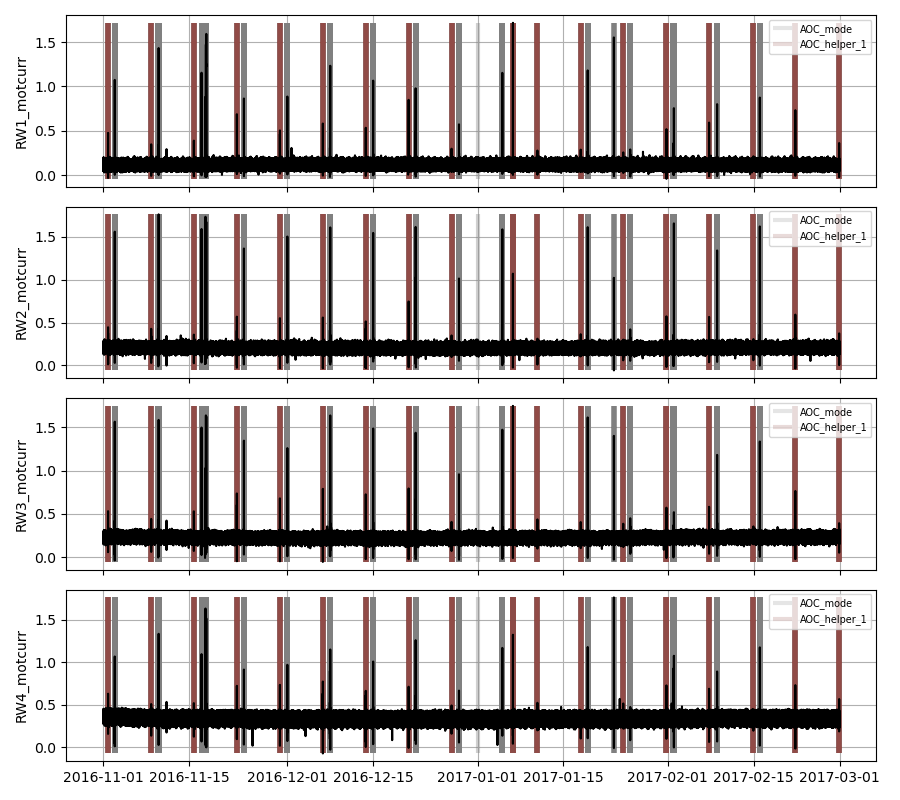

In [18]:
columns = list(df.columns[:4])
ncols = len(columns)
# wheels = ['RW1', 'RW2', 'RW3', 'RW4']

start = df.index[0]
end = start + pd.Timedelta(120, 'd')

fig, ax = plt.subplots(ncols, 1, figsize=(9, 2*ncols), sharex=True)
for i, col in enumerate(columns):
    # ax[i].vlines(df.loc[idx1[wheels[i]]][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     # **kwargs2, label=wheels[i], color='#498dd1')
    # for j, wheel in enumerate(ws[wheels[i]]):
        # ax[i].vlines(df.loc[idx1[wheel]][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     # **kwargs2, label=wheel, color=colors[j])
    ax[i].vlines(df.loc[idx2][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                 **kwargs, label='AOC_mode', color='gray')
    ax[i].vlines(df.loc[idx3][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                 **kwargs, label='AOC_helper_1', color='#914b47')
    
    ax[i].plot(df.loc[start:end, col], color='black')
    
    ax[i].grid(True)
    ax[i].set(ylabel=col)
    
    ax[i].legend(fontsize=7, loc='upper right')

fig.tight_layout()

2. Effect of AOC_mode and of the changes in RWx_cmd_sign

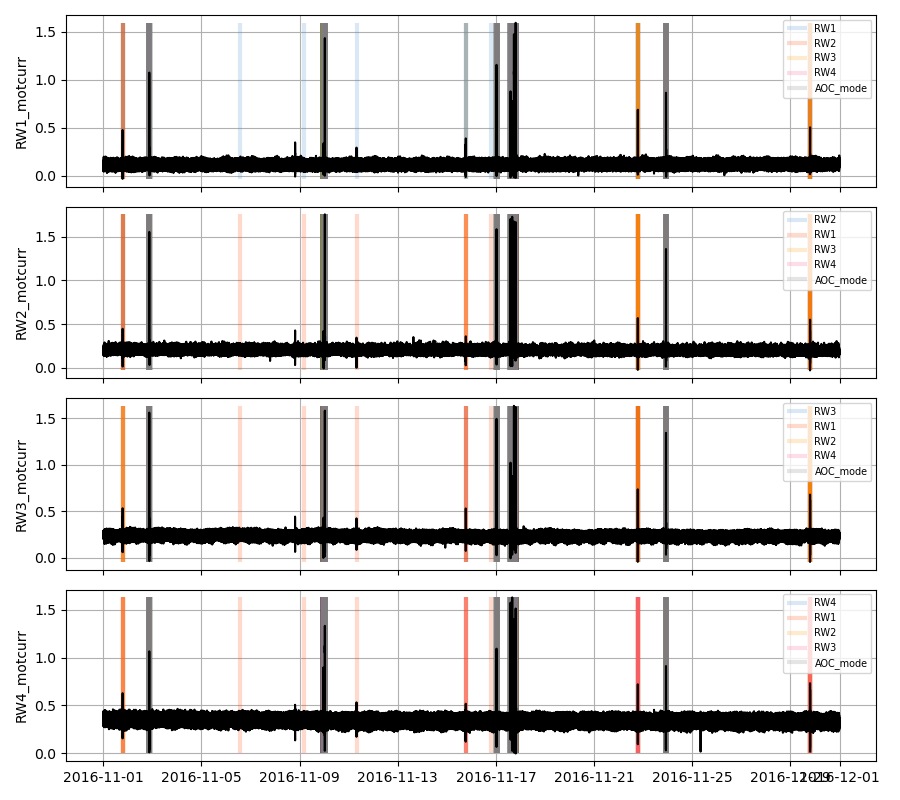

In [34]:
columns = list(df.columns[:4])
ncols = len(columns)
# wheels = ['RW1', 'RW2', 'RW3', 'RW4']

start = df.index[0]
end = start + pd.Timedelta(30, 'd')

fig, ax = plt.subplots(ncols, 1, figsize=(9, 2*ncols), sharex=True)
for i, col in enumerate(columns):
    ax[i].vlines(df.loc[idx1[wheels[i]]][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     **kwargs, label=wheels[i], color='#498dd1')
    for j, wheel in enumerate(ws[wheels[i]]):
        ax[i].vlines(df.loc[idx1[wheel]][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     **kwargs, label=wheel, color=colors[j])
    ax[i].vlines(df.loc[idx2][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                 **kwargs, label='AOC_mode', color='gray')
    # ax[i].vlines(df.loc[idx3][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
    #              **kwargs, label='AOC_helper_1', color='#914b47')
    
    ax[i].plot(df.loc[start:end, col], color='black')
    
    ax[i].grid(True)
    ax[i].set(ylabel=col)
    
    ax[i].legend(fontsize=7, loc='upper right')

fig.tight_layout()

3. Combined effect of the considered conditions

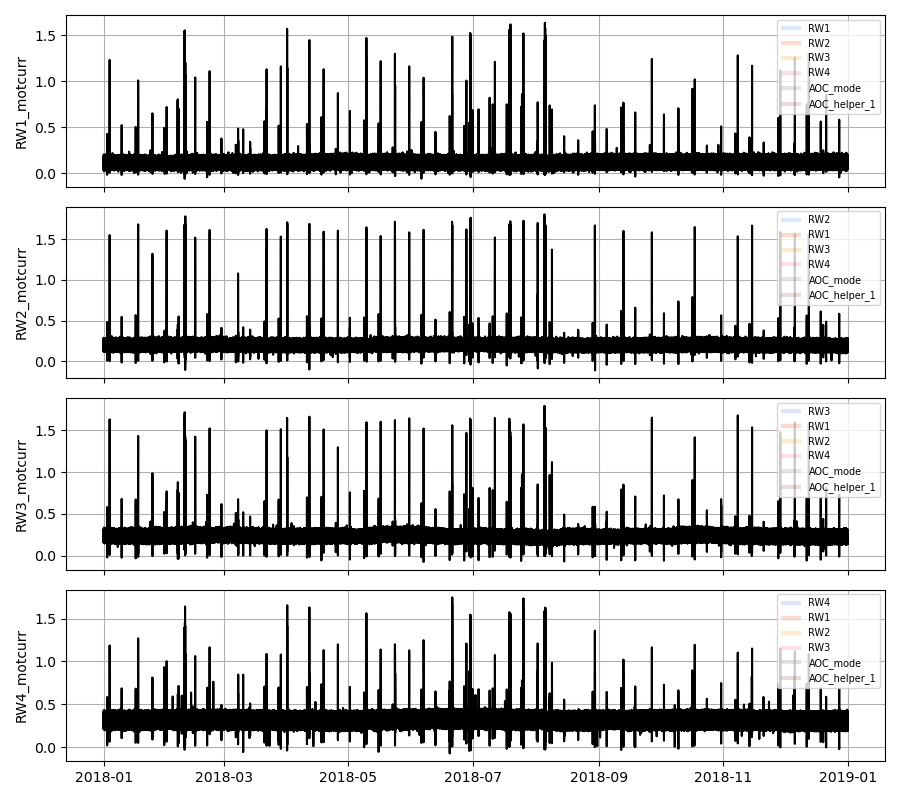

In [22]:
columns = list(df.columns[:4])
ncols = len(columns)
# wheels = ['RW1', 'RW2', 'RW3', 'RW4']

# start = df.index[0]
# end = start + pd.Timedelta(30, 'd')
start = extr_4s['2018'][0]
end = extr_4s['2018'][-1]

fig, ax = plt.subplots(ncols, 1, figsize=(9, 2*ncols), sharex=True)
for i, col in enumerate(columns):
    ax[i].vlines(df.loc[idx1[wheels[i]]][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     **kwargs, label=wheels[i], color='#498dd1')
    for j, wheel in enumerate(ws[wheels[i]]):
        ax[i].vlines(df.loc[idx1[wheel]][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     **kwargs, label=wheel, color=colors[j])
    ax[i].vlines(df.loc[idx2][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                 **kwargs, label='AOC_mode', color='gray')
    ax[i].vlines(df.loc[idx3][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                 **kwargs, label='AOC_helper_1', color='#914b47')
    
    ax[i].plot(df.loc[start:end, col], color='black')
    
    ax[i].grid(True)
    ax[i].set(ylabel=col)
    
    ax[i].legend(fontsize=7, loc='upper right')

fig.tight_layout()

Choose the RW of interest:

In [25]:
wheels_ = [1, 2, 3, 4]
# analog_quantities = ['motcurr', 'therm', 'speed', 'cmd_volt']
w = wheels_[2]
columns = [f'RW{w}_{quantity}' for quantity in analog_quantities]

In [26]:
columns

['RW3_motcurr', 'RW3_therm']

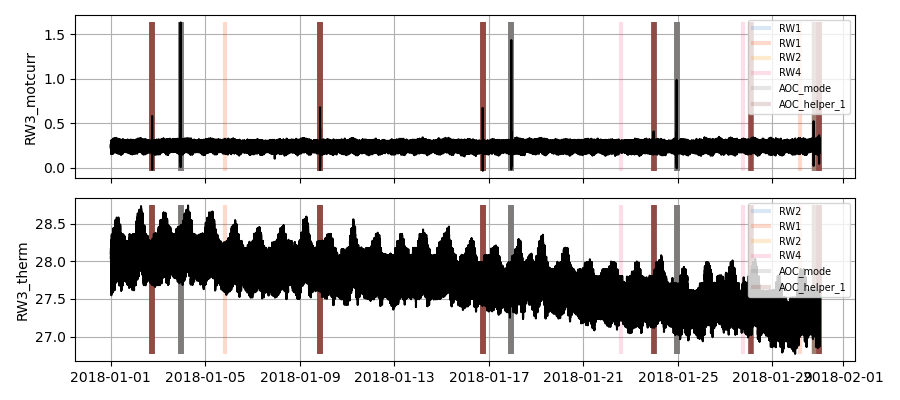

In [27]:
# columns = list(df.columns[:4])
columns = columns
ncols = len(columns)

offset = 9201599
start = df.index[offset]
# start = pd.to_datetime([extr_4s['2018'][0]])
end = start + pd.Timedelta(30, 'd')


fig, ax = plt.subplots(ncols, 1, figsize=(9, 2*ncols), sharex=True)
for i, col in enumerate(columns):
    
    ax[i].vlines(df.loc[idx1[f'RW{w}']][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     **kwargs, label=wheels[i], color='#498dd1')
    for j, wheel in enumerate(ws[f'RW{w}']):
        ax[i].vlines(df.loc[idx1[wheel]][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     **kwargs, label=wheel, color=colors[j])
        
    ax[i].vlines(df.loc[idx2][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                 **kwargs, label='AOC_mode', color='gray')
    ax[i].vlines(df.loc[idx3][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                 **kwargs, label='AOC_helper_1', color='#914b47')
    ax[i].plot(df.loc[start:end, col], color='black')
    # ax[i].plot(xdf.loc[start:end, col], color='black')
    
    ax[i].grid(True)
    ax[i].set(ylabel=col)
    
    ax[i].legend(fontsize=7, loc='upper right')

fig.tight_layout()

## Dataset cleaning (peak removal)

Quick loader for the data cleaned from the unwanted fluctuations occuring at indices `idx3`, `idx2` and `idx1`.

In [30]:
ts = '4s' # sampling period
path = '../data/FIORIRE/dataset_4s/'

In [31]:
xdf = pd.read_pickle(os.path.join(path, f'all_2016-2018_clean_{ts}.pkl'))

Peak removal procedure

In [32]:
def filter_spikes(df, index_list, timedelta, columns):
    '''
    Parameters
    -----------
    df: pandas DataFrame
    index_list: list of indices' lists corresponding to 
                timestamps for which irregularities take place
    timedelta: interval of time that will be taken before
               and after the timestamp of interest
    columns: list of columns whose values will be modified
    --------
    Returns
    pandas DataFrame modified with NaN values wherever 
    an irregularity is located
    
    '''
    for idx in index_list:
        interval = [idx - timedelta, idx + timedelta]
        df[(df.index > interval[0]) & (df.index < interval[1])] = np.nan
        #df.at[interval[0]:interval[1], columns] = np.nan
        
    return df

In [119]:
# define the timedelta
td = pd.to_timedelta('10m')

In [113]:
channels = ["RW1_motcurr"]

In [120]:
#df[(df.index > interval[0]) & (df.index < interval[1])]

In [121]:
#df.at[interval[0]:interval[1], channels[0]]

In [122]:
# conditions related to AOC_helper_1
xdf = filter_spikes(df, idx3, td, channels)
# conditions related to AOC_mode
xdf = filter_spikes(df, idx2, td, channels)
# conditions related to RWx_cmd_Ssgn
for i, wheel in enumerate(wheels):
    xdf = filter_spikes(df, idx1[wheel], td, channels)

In [126]:
xdf.loc[idx3]

,RW1_motcurr,RW2_motcurr,RW3_motcurr,RW4_motcurr,RW1_therm,RW2_therm,RW3_therm,RW4_therm,RW1_speed,RW2_speed,...,RW1_cmd_volt,RW2_cmd_volt,RW3_cmd_volt,RW4_cmd_volt,RW1_cmd_sign,RW2_cmd_sign,RW3_cmd_sign,RW4_cmd_sign,AOC_mode,AOC_helper_1
2016-11-01 18:53:28+00:00,NaN,0.202106,NaN,0.345712,18.370975,24.253000,NaN,24.741548,-59.431297,45.228377,...,0.796686,1.163594,1.571727,2.073468,0.0,1.0,0.0,1.0,1282.0,131074.0
2016-11-01 18:53:32+00:00,NaN,0.203318,NaN,0.339966,18.372542,24.260206,NaN,24.717052,-59.437870,45.199145,...,0.961692,1.261767,1.419129,2.005698,0.0,1.0,0.0,1.0,1282.0,131074.0
2016-11-01 18:53:36+00:00,NaN,0.195075,NaN,0.342997,18.365104,24.194179,NaN,24.705324,-59.512736,45.198032,...,0.905909,1.188070,1.472204,2.061107,0.0,1.0,0.0,1.0,1282.0,131074.0
2016-11-01 18:53:40+00:00,NaN,0.190109,NaN,0.348142,18.414865,24.218515,NaN,24.686633,-59.553533,45.169466,...,0.800479,1.119920,1.545365,2.121082,0.0,1.0,0.0,1.0,1282.0,131074.0
2016-11-01 18:53:44+00:00,NaN,0.197026,NaN,0.359247,18.371106,24.236595,NaN,24.698727,-59.546362,45.108501,...,0.754568,1.174400,1.511881,2.135128,0.0,1.0,0.0,1.0,1282.0,131074.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 19:00:40+00:00,NaN,0.176947,0.210316,0.317691,19.955394,26.938820,28.543955,24.654828,-54.327023,49.846744,...,1.133605,1.213397,1.245823,1.822490,0.0,1.0,0.0,1.0,1282.0,131074.0
2018-12-27 19:00:44+00:00,NaN,0.076900,0.356306,0.425530,19.970324,26.891604,28.460143,24.682319,-54.376913,49.764758,...,0.199993,0.569670,1.896125,2.410234,0.0,1.0,0.0,1.0,1282.0,131074.0
2018-12-27 19:00:48+00:00,NaN,0.199166,0.234959,0.316099,19.998343,26.849058,28.449016,24.664172,-54.141818,49.479209,...,0.688821,1.133851,1.543227,1.980532,0.0,1.0,0.0,1.0,1282.0,131074.0
2018-12-27 19:00:52+00:00,NaN,0.287596,0.113150,0.218735,19.985032,26.866430,28.532866,24.675591,-54.107340,49.483998,...,1.112776,1.523784,0.955601,1.542545,0.0,1.0,0.0,1.0,1282.0,131074.0


## Standardization

Quick loader for the clean data standardized by performing, instance-wise and for each channel $x$, the operation:
$$z_i = \frac{x_i - \mu_x}{\sigma_x}$$
Note: the test set should then be standardized in the same manner by considering the same $\mu_x$ and $\sigma_x$ extracted from the training set.

In [11]:
ts = '4s' # sampling period
path = f'../data/fiorire/sentinel/dataset_{ts}/'

In [13]:
xdf = pd.read_pickle(os.path.join(path, f'all_2016-2018_clean_std_{ts}.pkl'))

In [ ]:
!python

Python 3.10.6 (main, Oct  7 2022, 20:19:58) [GCC 11.2.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 

Select channels of interest

In [ ]:
# channels = []

In [129]:
for i, ch in enumerate(channels):
    xdf[ch] = (xdf[ch] - xdf[ch].mean())/xdf[ch].std()

In [130]:
df_bkp = df.copy()

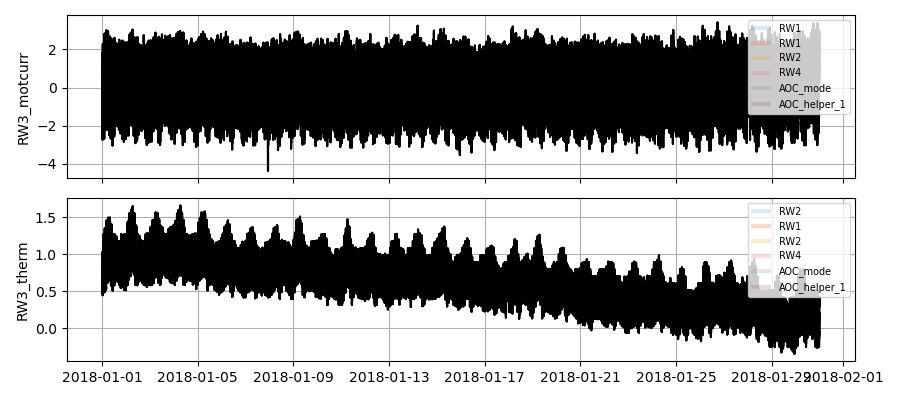

In [131]:
df = xdf
# columns = list(df.columns[:4])
columns = columns
ncols = len(columns)

offset = 9201599
start = df.index[offset]
# start = pd.to_datetime([extr_4s['2018'][0]])
end = start + pd.Timedelta(30, 'd')


fig, ax = plt.subplots(ncols, 1, figsize=(9, 2*ncols), sharex=True)
for i, col in enumerate(columns):
    
    ax[i].vlines(df.loc[idx1[f'RW{w}']][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     **kwargs, label=wheels[i], color='#498dd1')
    for j, wheel in enumerate(ws[f'RW{w}']):
        ax[i].vlines(df.loc[idx1[wheel]][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                     **kwargs, label=wheel, color=colors[j])
        
    ax[i].vlines(df.loc[idx2][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                 **kwargs, label='AOC_mode', color='gray')
    ax[i].vlines(df.loc[idx3][start:end].index, min(df.loc[start:end, col]), max(df.loc[start:end, col]), 
                 **kwargs, label='AOC_helper_1', color='#914b47')
    ax[i].plot(df.loc[start:end, col], color='black')
    ax[i].plot(df.loc[start:end, col], color='black')
    
    ax[i].grid(True)
    ax[i].set(ylabel=col)
    
    ax[i].legend(fontsize=7, loc='upper right')

fig.tight_layout()

## Windowing

With the adopted procedure, if (e.g.) the sampling period is $t_s = 2s$, then a window of $n=30$ samples will be equivalent to observing a time interval of $1$ minute.

In [133]:
n_list = [30, 300, 600, 1200, 1800] # these are just random choices

In [134]:
def infer_freq(index):
    ''' infer sample frequency from index '''
    freq = index.freq
    if freq is None:
        freq = pd.Series(index).diff().median()
    return freq

def window(x, n, freq=None):
    '''
    Split a dataset in windows and arrange each window as rows. 
    Dataset is assumed to have pandas.DatetimeIndex as index. 
    The timestamp assigned to each window correspond to the timestamp of the
    windows' first element.
    
    Parameters
    ----------
    x: pandas.DataFrame,
        dataset or series to split into windows.
    n: int,
        number of sample in each window
    freq: pandas.Timedelta, optional (default None)
        sample frequency for the input dataset. If not given, frequency is
        inferred from the dataset as the median of the interval between
        successive samples.
    
    Returns
    -------
    pandas.DataFrame,
        dataframe where windows are arranged as rows.
    '''
    # retrieve freq if not specified
    if freq is None:
        freq = infer_freq(x.index) # infer sample time

    y = x.dropna()
    # filter out windows with less than `n` elements
    y = y.groupby(y.index.floor(n*freq)).filter(lambda x: len(x)==n)
    # split data in windows and arrange them as rows
    Y = np.vstack(list(map(
        lambda x: x.T.reshape(-1), # reshape single window
        np.split(y.values, len(y)//n)))) # split data into windows
    # build output dataframe
    index = y.resample(n*freq).asfreq().dropna().index
    columns = pd.MultiIndex.from_product(
        iterables=[x.columns, range(n)], 
        names=['channel', 'feature'])
    y = pd.DataFrame(data=Y, columns=columns, index=index).asfreq(n*freq)
    
    return y

Produce time windows of a single quantity

In [135]:
chan = ['RW1_motcurr']
Xdf = window(xdf[chan], 300).dropna()

In [136]:
Xdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55997 entries, 2016-11-01 00:20:00+00:00 to 2018-12-31 23:20:00+00:00
Columns: 300 entries, ('RW1_motcurr', 0) to ('RW1_motcurr', 299)
dtypes: float64(300)
memory usage: 128.6 MB


<AxesSubplot:xlabel='channel,feature', ylabel='RW3_therm'>

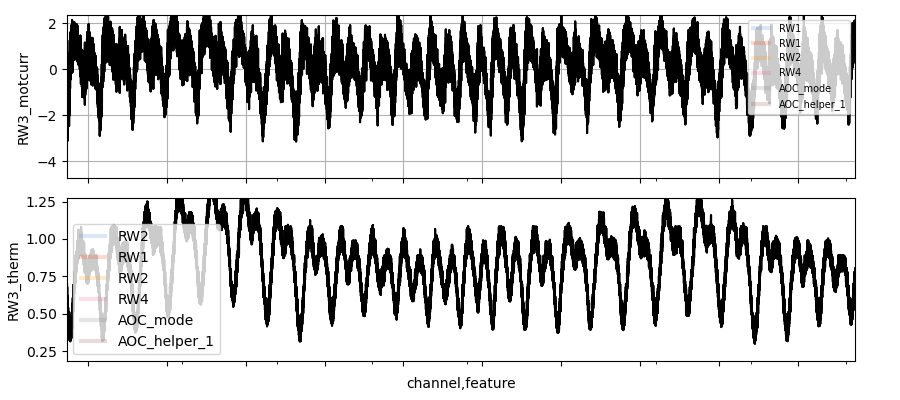

In [137]:
# plt.close('all')
Xdf.iloc[0].plot()

Produce a collection of windowed datasets and store in a dict that can be indexed based on window length n:

In [138]:
Xdf = {}

for n in n_list:
    Xdf[n] = window(xdf[chan], n).dropna()

Produce time windows of multiple quantities

In [140]:
chan = channels[:4]
Xdf = window(xdf[chan], 300).dropna()